#Speeding Up Convergence for Finite Element Discretization
----
####This notebook contains a problem statement and accompanying code for solving a family of [PDEs](https://en.wikipedia.org/wiki/Poisson%27s_equation) through [finite element methods](https://en.wikipedia.org/wiki/Finite_element_method).

####More specifically, I compare convergence rates of two related FEM formulations for computing numerical solutions to Poisson's equation - [Gradient Descent](https://en.wikipedia.org/wiki/Gradient_discretisation_method), and [Multigrid](https://en.wikipedia.org/wiki/Multigrid_method). This analysis starts by theoretically formulating an optimization problem to be solved through a discretized Gradient Descent algorithm, and then adapting this to Multigrid to accelerate convergence towards an exact solution. We'll be using the one-dimensional [P1](https://en.wikipedia.org/wiki/Finite_element_method#Illustrative_problems_P1_and_P2) problem formulation of FEM.



In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import time

##Mathematical Motivation:


###1.) Defining the Optimization Problem
----



Consider an unknown function $u(x)$ and known function $f(x)$ such that

$P1$:
\begin{aligned}
-u''(x)&= f(x), \,\, 0<x<1, \\
 u(0)&=u(1)=0.
\end{aligned}

Using the weak formulation of $P1$, it can be shown with some fancy math that
if $u(x)$ solves the above equations, then finding $u(x)$ is an equivalent problem to optimizing


\begin{equation}
u = \text{arg}\,\min\limits_{v}\, J(v)
\end{equation}



where

\begin{equation}
J(v) = \frac12 \int_{0}^{1} |v(x)'|^2 \; dx
- \int_{0}^{1} f(x)v(x) \; dx
\end{equation}

for some $v(x) \in (0,1)$.


###2.) Discretizing with Gradient Descent
----
To set up gradient descent for FEM, we assume $f(x)=1$, so that integrating $u''(x)$ twice gives the exact solution $u(x)=\frac{1}{2}x(1-x)$. 


Applying finite element discretization of $P1$ using a partition with grid points 
$x_i=\frac{i}{n+1}, i=0,1,\cdots,n+1$ then gives us the following convolution 

\begin{equation}
A\ast \mu =b
\end{equation}

where $A=\frac{1}{h}[-1,2,-1]$, and $\mu$ and $b$ are discretized versions of the continuous functions $u$ and $f$, respectively.

We can then use gradient descent to recast the above minimization problem in a discretized form

$$
\mu^{m} = \mu^{m-1} + \frac{h}{4} (b- A* \mu^{m-1}),~~ m=1,2,3,...,M.
$$

where $M$ is the number of iterations, and $\frac{h}{4}$ is a regularization parameter. 


Next, by defining a smoother $S^\ell$ such that 

$$\mu^1 = S_0^\ell b = \frac{h_\ell}{4} b,$$
$$\mu^2 = S_1^\ell b= S_0^\ell + S_0^\ell(b- A* \mu^{m-1})$$

We obtain the following update rule gradient descent of Poisson's equation:


$$\mu^j = \mu^{j-1} + S^\ell(b- A* \mu^{m-1}),~~ j=1,2,3,...,J.$$

where $J$ is the grid level as defind by the number of iterations of the smoothing operator.


The above numerical solution $\mu$ will converge to the exact solution $u$ with a high enough number of iterations.

----

##Implementing Discretized Gradient Descent in Python


Now that we've gotten some of the mathematical theory behind what we're doing by utilizing gradient descent for FEM, let's put it all together in code. 

Pseudo-code for discretized Gradient Descent:

$$
\begin{align}
&\text{for    }  m =  1,2,...,M\\
&~~~~\text{for    }  i,j = 1: n\\
&~~~~~~~~u_{i,j}^{m} = u_{i,j}^{m-1}-\eta(f_{i,j}-(A\ast u^{m-1})_{i,j})\\
&~~~~\text{endfor}\\
&\text{endfor}
\end{align} 
$$


First we need to define the parameters we'll be using. Let's start with a grid level J = 4 and break that up into n = 15 inner grid points, giving us 16 grid intervals. We'll try M = 10 iterations to start.

In [57]:
J = 4                                # grid level
M = 100                              # number of iterations
n = 2**J - 1                         # number of inner grid points
h = 1/ 2**J                          # length of grid interval
x = np.arange(1, n + 1) *h           # grid points
u = (x*(1-x))/2                      # true solution at grid points
b = np.ones(n)*h                     # right-hand-size term
u1 = np.random.rand(n)*2-1           # initial value for u

First define smoothing iterations for one iteration of gradient descent: $\mu^j = \mu^{j-1} + S^\ell(b- A* \mu^{m-1}),~~ j=1,2,3,...,J.$




In [58]:
def FEM_GD(u1,n,h,A,b):
  Au_temp = np.array([u1[0]*A[1]+u1[1]*A[2]])
  for j in np.arange(1,len(u1)-1):
      Au_temp = np.append(Au_temp,np.dot(u1[j-1:j+2],A))
  Au = np.append(Au_temp, u1[-2]*A[0] + u1[-1]*A[1])
  u1 = u1 + h/4 * (b - Au)
  return u1, Au

Then call function to get initial u1, and wrap this in the number of iterations $M$.

Record computational time and L2 normalized error of the residual, $e^m = \sqrt{\sum_{i=0}^{n+1}|(A* \mu^{m}- b)_i |^2}$

In [59]:
gd_error_list = []                            
t0 = time.time()                    
A = np.array([-1, 2, -1]) /h       

for m in range(M):
  u1, null = FEM_GD(u1, m, h, A, b)
  null, Au = FEM_GD(u1, m, h, A, b)
  gd_error_list.append(np.linalg.norm(Au-b))  

gd_time_cost = time.time() - t0
print('Time cost', gd_time_cost)
print('Error at iteration {}: {}'.format(M, gd_error_list[-1]))

Time cost 0.026829242706298828
Error at iteration 100: 0.08692338555826352


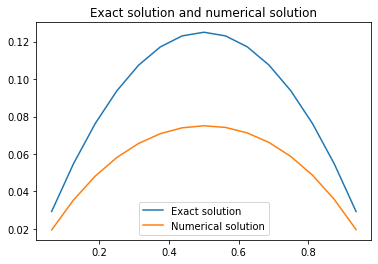

In [60]:
# Overlay exact solution and numerical solution
plt.figure()
plt.title('Exact solution and numerical solution')
plot = plt.plot(x,u,label='Exact solution')
plot = plt.plot(x,u1,label='Numerical solution')
plt.legend()
plt.show()

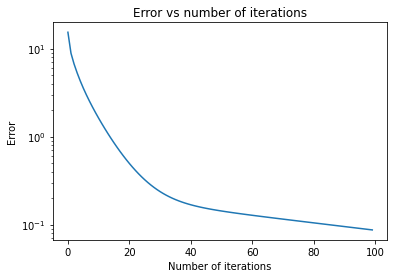

In [61]:
# Display error vs iterations 
plt.figure()
plt.title('Error vs number of iterations')
plot = plt.plot(gd_error_list)
plt.xlabel('Number of iterations')
plt.yscale('log')
plt.ylabel('Error')
plt.show()

It looks like our error is steadily decreasing, but after 100 iterations of gradient descent we still have a sizable difference between the numerical solution we computed and the exact solution.


###3.) Moving to Multigrid
----

We can implement Multigrid for FEM with the following pseudo-code

Pseudo-code for Multigrid: $u^{m} = MG1(u^{m-1},f, J, \nu)\ ,~~~m=1,2,...,M$


$$
\begin{align}
&\text{for }~ m =  1,2,...,M\\
&~~{\text{initialize:}} ~b^1 = b, \mu^1 = \mu^0\\
&~~{\text{Restriction from fine to course grid size:}}\\
&~~{\text{for}} ~ l = 1,2,...,J\\
&~~~~{\text{Smoothing:}}\\
&~~~~{\text{for}} ~ i = 1,2,...,v_l\\
&~~~~~~u^{l} = u^{l} + S^{l} * (b^{l} - A_{l} * \mu^l)\\
&~~~~{\text{end for}}\\
&~~~~\mu^{l+1} = 0\\
&~~~~b^{l+1} = R *_2 (b^{l} - A_{l} * \mu^l) \\
&~~~~A_{l+1} = R *_2 A_l * (R *_2^{\mathsf{T}})\\
&~~{\text{end for}}\\
&~~{\text{Restriction from course to fine grid size:}}\\
&~~{\text{for}} ~ l = J-1, J, J+1,...,1\\
&~~~~\mu^l = \mu^l +   R *_2^{\mathsf{T}} \mu^{l+1}\\
&~~{\text{end for}}\\
&~~{\mu = \mu^l}\\
&{\text{end for}}\\
\end{align} 
$$

NOTE: You can find the cleaned up object oriented implementations of the same mathematical approach generalized to higher dimensions in 'Multigrid.py'. To help keep this notebook relatively small and tidy, the following code block shows a functional, brute force implementations of MG for FEM. 

In [62]:
J = 4                                # grid level
M = 100                              # number of iterations
n = 2**J - 1                         # number of inner grid points
h = 1/ 2**J                          # length of grid interval
x = np.arange(1, n + 1) *h           # grid points
u = (x*(1-x))/2                      # true solution at grid points
b = np.ones(n)*h                     # right-hand-size term
u1 = np.random.rand(n)*2-1           # initial value for u

In [63]:
def FEM_MG1(b, u0, J, v):
  B=[0,b]
  U=[0,u0]
  R=np.array([1/2,1,1/2])

  for l in np.arange(1,J+1):
    h_l=1/2**(J+1-l)
    A=np.array([-1,2,-1]/h_l)

    if l<J:
      for i in np.arange(0,v[l-1]):
        temp=np.array([U[l][0]*A[1]+U[l][1]*A[2]])

        for j in np.arange(1,len(U[l])-1):
            temp=np.append(temp,np.dot(U[l][j-1:j+2],A))
        temp=np.append(temp,U[l][-2]*A[0]+U[l][-1]*A[1])
        U[l]+=1/4*h_l*(B[l]-temp)

      U.append(np.zeros((len(U[l])-1)//2))
      newb=[]
      temp=np.array([U[l][0]*A[1]+U[l][1]*A[2]])
      
      for j in np.arange(1,len(U[l])-1):
         temp=np.append(temp,np.dot(U[l][j-1:j+2],A))
      temp=np.append(temp,U[l][-2]*A[0]+U[l][-1]*A[1])
    
      for k in range((len(U[l])-1)//2):
        newb.append(np.dot((B[l]-temp)[2*k:2*k+3],R))
      B.append(newb)
    else:
      for i in np.arange(0,v[l-1]):
        temp=np.array(U[l][0]*A[1])
        U[l]+=1/4*h_l*(B[l]-temp)
  
  for l in np.arange(J-1,0,-1):
    temp=[1/2*U[l+1][0]]
  
    for i in np.arange(1,len(U[l+1])*2):
      if i%2==1:
        temp.append(U[l+1][(i-1)//2])
      else:
        temp.append(1/2*(U[l+1][(i-2)//2]+U[l+1][i//2]))
    temp.append(1/2*U[l+1][-1])
    U[l]+=temp
    
  return U[1], temp


mg_error_list = []                            
t0 = time.time()                    
A = np.array([-1, 2, -1]) /h       

for m in range(M):
  u1, null = FEM_MG1(b,u1,J,[2,2,2,2])
  null, Au = FEM_GD(u1, m, h, A, b)
  mg_error_list.append(np.linalg.norm(Au-b))  
mg_time_cost = time.time() - t0
print('Time cost', mg_time_cost)
print('Error at iteration {}: {}'.format(M, mg_error_list[-1]))

Time cost 0.09953904151916504
Error at iteration 100: 6.181460191301304e-16


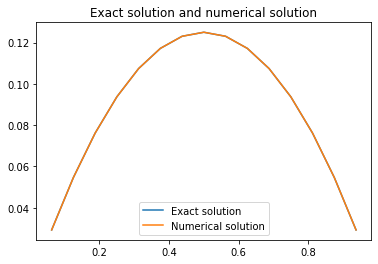

In [64]:
# Overlay exact solution and numerical solution
plt.figure()
plt.title('Exact solution and numerical solution')
plot = plt.plot(x,u,label='Exact solution')
plot = plt.plot(x,u1,label='Numerical solution')
plt.legend()
plt.show()

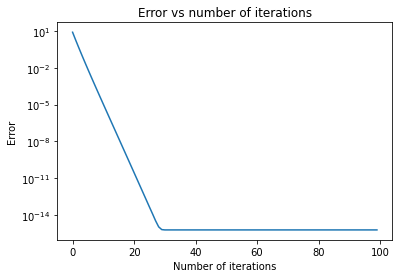

In [65]:
# Display error vs iterations 
plt.figure()
plt.title('Error vs number of iterations')
plot = plt.plot(mg_error_list)
plt.xlabel('Number of iterations')
plt.yscale('log')
plt.ylabel('Error')
plt.show()

In [36]:
print('Multigrid error after 10 iterations: {},  Gradient Descent error after 10 iterations: {}'.format(mg_error_list[-1], gd_error_list[-1]))

Multigrid error after 10 iterations: 8.899114524108741e-16,  Gradient Descent error after 10 iterations: 0.872609308922711


In [38]:
print('Multigrid time cost for 10 iterations: {},  Gradient Descent time cost for 10 iterations: {}'.format(mg_time_cost, gd_time_cost))

Multigrid time cost for 10 iterations: 0.009506464004516602,  Gradient Descent time cost for 10 iterations: 0.024457693099975586


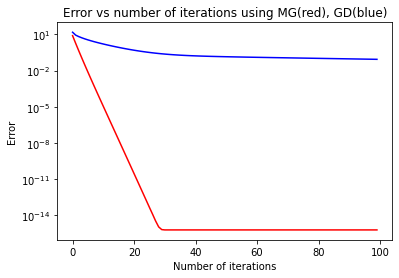

In [66]:
plt.figure()
plt.title('Error vs number of iterations using MG(red), GD(blue)')
plot = plt.plot(mg_error_list,'r-', gd_error_list, 'b-')
plt.xlabel('Number of iterations')
plt.yscale('log')
plt.ylabel('Error')
plt.show()

Looks like Multigrid converges in a far fewer number of iterations than gradient descent, but has a slightly higher time cost.
Let's evaluate the minimum number of iterations it takes to acheive error less than $10^{-4}$ to compare convergence rates.

In [51]:
J = 4                                # grid level
M = 10                               # number of iterations
n = 2**J - 1                         # number of inner grid points
h = 1/ 2**J                          # length of grid interval
x = np.arange(1, n + 1) *h           # grid points
u = (x*(1-x))/2                      # true solution at grid points
b = np.ones(n)*h                     # right-hand-size term
u1 = np.random.rand(n)*2-1           # initial value for u

gd_error = []                            
t0 = time.time()                    
A = np.array([-1, 2, -1]) /h       
m=0

u1, null = FEM_GD(u1, m, h, A, b)
null, Au = FEM_GD(u1, m, h, A, b)
gd_error.append(np.linalg.norm(Au-b))  

while gd_error[-1] > 1e-4:
  u1, null = FEM_GD(u1, m, h, A, b)
  null, Au = FEM_GD(u1, m, h, A, b)
  gd_error.append(np.linalg.norm(Au-b))  
  m+=1
gd_time_cost = time.time() - t0

print('Gradient Descent:')
print('The minumum M to achieve error less than 1e-5 m = ', m)
print('Time cost for m iterations is ', time.time() - t0)

Gradient Descent:
The minumum M to achieve error less than 1e-4 m =  842
Time cost for m iterations is  0.21818208694458008


In [56]:
J = 4                                # grid level
M = 10                               # number of iterations
n = 2**J - 1                         # number of inner grid points
h = 1/ 2**J                          # length of grid interval
x = np.arange(1, n + 1) *h           # grid points
u = (x*(1-x))/2                      # true solution at grid points
b = np.ones(n)*h                     # right-hand-size term
u1 = np.random.rand(n)*2-1           # initial value for u

mg_error = []                            
t0 = time.time()                    
A = np.array([-1, 2, -1]) /h       
m=0

u1, null = FEM_MG1(b,u1,J,[2,2,2,2])
null, Au = FEM_GD(u1, m, h, A, b)
mg_error.append(np.linalg.norm(Au-b))  

while mg_error[-1] > 1e-5:
  u1, null = FEM_MG1(b,u1,J,[2,2,2,2])
  null, Au = FEM_GD(u1, m, h, A, b)
  mg_error.append(np.linalg.norm(Au-b))   
  m+=1
gd_time_cost = time.time() - t0

print('Multigrid:')
print('The minumum M to achieve error less than 1e-4 m = ', m)
print('Time cost for m iterations is ', time.time() - t0)

Multigrid:
The minumum M to achieve error less than 1e-4 m =  11
Time cost for m iterations is  0.013488292694091797


| Method           |  # iterations | computational time |
|:-----------------|:--------------------|:-------------------|
| Multigrid |         11     |     0.013488292694091797               |
| Gradient Descent    |   842|0.21818208694458008    

We can see that despite taking longer to compute one iteration, multigrid requires much less overall compute time to converge than gradient descent!